In [1]:
import pandas
import math
import emcee
import random
import numpy as np
import matplotlib.pyplot as plt
from pandas_datareader import data
from datetime import date
from matplotlib import rc
import corner
rc('font', weight='bold')

In [2]:
def shiller_pe_model(pe_ratio, dividend_yield, g=0.063, numerator=15, T=10.0):
    return ((1 + g)*np.power(numerator / pe_ratio, 1/T)  - 1 + dividend_yield)*100

def shiller_pe_model_all(pe_ratios, dividend_yields, g=0.063, numerator=15, T=10.0):
    return [shiller_pe_model(pe_ratio, dividend_yield, g, numerator, T) for 
           pe_ratio, dividend_yield in zip(pe_ratios, dividend_yields)]

In [3]:
excel_file = pandas.ExcelFile("http://www.econ.yale.edu/~shiller/data/ie_data.xls")
shiller_data = excel_file.parse('Data', skiprows=7)

In [4]:
# clean up the data
for name in shiller_data.columns:
    if 'Unnamed' in name:
        del shiller_data[name]
# remove nan rows at the end
shiller_data = shiller_data[shiller_data.Date.map(lambda x: not math.isnan(x))]
# convert the decimal dates
def convert_date(decimal_format):
    return date(int(decimal_format), int(round((decimal_format - int(decimal_format))*100)), 1)
shiller_data['Date'] = shiller_data.apply(lambda row: convert_date(row['Date']), 1)

In [5]:
# add in a nominal dividend yield column
shiller_data['div_yield'] = pandas.to_numeric(shiller_data['D'] / shiller_data['P'], errors='coerce')

In [6]:
# find the last CAPE and dividend that is not NaN
last_cape = len(shiller_data['CAPE'])
for i in range(len(shiller_data['CAPE'])-1, -1, -1):
    if not math.isnan(shiller_data['CAPE'].ix[i]) and not math.isnan(shiller_data['D'].ix[i]):
        last_cape = i + 1
        break

In [7]:
start_index = shiller_data.Date[shiller_data.Date == date(1945, 1, 1)].index[0] # go back to 1945
# exclusive, need to be able to calculate 10 years of returns
end_index = last_cape - 10*12

In [8]:
def calculate_return(stock_index, dividends, start_index, end_index, years):
    total_dividends = sum(dividends[start_index + 12:end_index+1:12])
    total_return = (stock_index[end_index] + total_dividends) / stock_index[start_index]
    return (math.pow(total_return, 1 / years) - 1)*100

In [9]:
# calculate the returns for each year
ten_year_return = []
dates = shiller_data.Date.ix[start_index:end_index-1]
sp_price = shiller_data.P.values
dividends = shiller_data.D.values
for i in range(start_index, end_index):
    ten_year_return.append(calculate_return(sp_price, dividends, i, i + 10 * 12, 10))

In [10]:
# calculate the predicted returns based on the shiller PE model
shiller_data['cape_model'] = shiller_data.apply(lambda row: shiller_pe_model(row['CAPE'], row['div_yield']), 1)

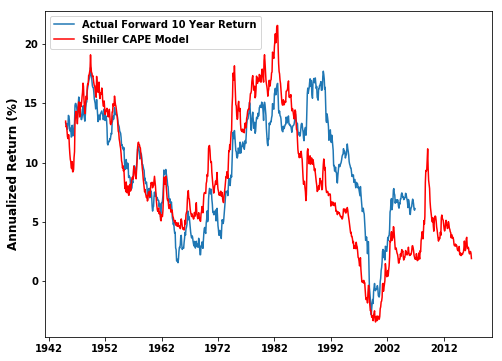

In [11]:
fig = plt.figure(0, figsize=(8,6))
plt.plot(dates, ten_year_return, label='Actual Forward 10 Year Return')
plt.plot(shiller_data.Date.values[start_index:-1], shiller_data['cape_model'].values[start_index:-1], 'r', label='Shiller CAPE Model')
plt.ylabel('Annualized Return (%)', fontsize=12, fontweight='bold')
plt.legend()
plt.show()

In [48]:
# go back 3 because we might not have a dividend yield yet
print("CAPE as of {} is {} and dividend rate is {}".format(shiller_data.Date.tail(4).values[0], 
                                                           shiller_data.CAPE.tail(4).values[0],
                                                          shiller_data.div_yield.tail(4).values[0]))
print("Shiller PE model predicts a 10 year annualized return of {}".format(shiller_pe_model(shiller_data.CAPE.tail(4).values[0], 
                                                                                shiller_data.div_yield.tail(4).values[0])))

CAPE as of 2016-12-01 is 27.93059071741077 and dividend rate is 0.02034157827501636
Shiller PE model predicts a 10 year annualized return of 1.927001930895943


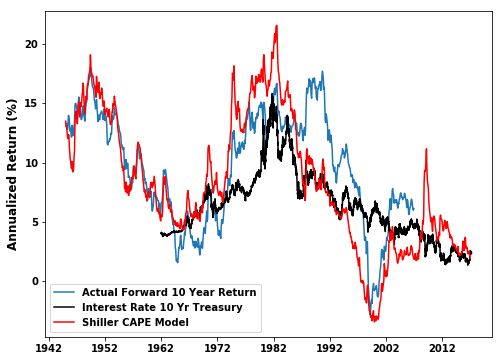

In [13]:
# 10 year treasury interest rate
treasury = data.DataReader("^TNX", "yahoo", shiller_data.Date.values[start_index], shiller_data.Date.values[-1])
fig = plt.figure(0, figsize=(8,6))
plt.plot(dates, ten_year_return, label='Actual Forward 10 Year Return')
plt.plot(treasury.index, treasury.Close, c="k", label='Interest Rate 10 Yr Treasury')
plt.plot(shiller_data.Date.values[start_index:-1], shiller_data['cape_model'].values[start_index:-1], 'r', label='Shiller CAPE Model')
plt.ylabel('Annualized Return (%)', fontsize=12, fontweight='bold')
plt.legend()
plt.show()

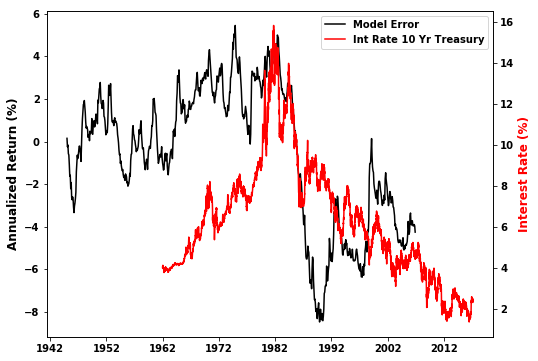

In [52]:
fig,ax1 = plt.subplots(figsize=(8,6))
y1, = ax1.plot(dates, shiller_data['cape_model'].values[start_index:end_index] - ten_year_return, label='Model Error', c="k")
ax1.set_ylabel('Annualized Return (%)', fontsize=12, fontweight='bold', color="k")
ax2=ax1.twinx()
y2, = ax2.plot(treasury.index, treasury.Close,label='Int Rate 10 Yr Treasury', c="r")
ax2.set_ylabel('Interest Rate (%)', fontsize=12, fontweight='bold', color="r")
plt.legend(handles=[y1, y2])
plt.show()

In [15]:
capes = np.asarray(shiller_data['CAPE'].values[start_index:end_index])
div_yield = np.asarray(shiller_data['div_yield'].values[start_index:end_index])
actual = np.asarray(ten_year_return)
baseline = np.asarray(shiller_pe_model(capes, div_yield))
baseline_error = actual - baseline
# estimate of the variance
variance = np.dot(baseline_error, baseline_error) / (len(baseline) - 2)
def lnprob(theta):
    g, M = theta
    if g < 0 or M < 0:
        return -np.inf
    pred = shiller_pe_model(capes, div_yield, g, M)
    error = actual - pred
    return -0.5*np.dot(error, error) / variance

In [16]:
nwalkers = 100
ndim = 2
p0 = np.array([[0.063, 15.0],]*nwalkers)
# perturb the starting parameters
p0 = p0 * (0.9 + 0.2 * np.random.rand(nwalkers, ndim))

In [17]:
print(np.mean(p0[:,0]))
print(np.mean(p0[:,1]))

0.0632274848251
14.9702720379


In [18]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob)

# burn-in
pos, prob, state = sampler.run_mcmc(p0, 500)
sampler.reset()

sampler.run_mcmc(pos, 2000)

print(np.mean(sampler.flatchain[:,0]))
print(np.mean(sampler.flatchain[:,1]))
# print(np.mean(sampler.flatchain[:,2]))
print("Mean acceptance fraction: {0:.3f}"
                .format(np.mean(sampler.acceptance_fraction)))

0.0678547932513
16.9954235765
Mean acceptance fraction: 0.341


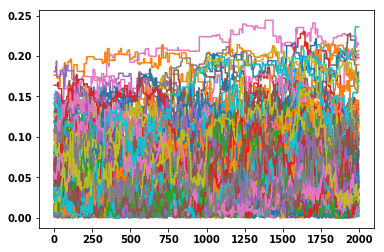

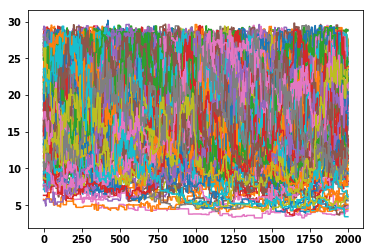

In [19]:
plt.figure(0)
for i in range(nwalkers):
    plt.plot(sampler.chain[i,:,0])
plt.show()

plt.figure(1)
for i in range(nwalkers):
    plt.plot(sampler.chain[i,:,1])
plt.show()

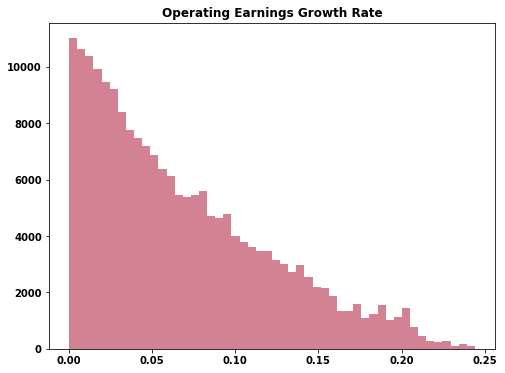

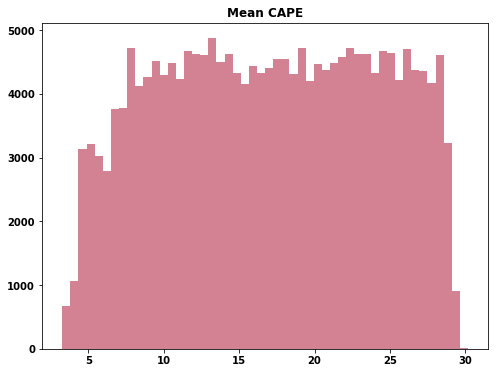

In [20]:
titles = ['Operating Earnings Growth Rate', 'Mean CAPE']
for i in range(ndim):
    plt.figure(figsize=(8,6))
    plt.hist(sampler.flatchain[:,i], 50, histtype="stepfilled", color="#A60628", alpha=0.5)
    plt.title("{}".format(titles[i]), fontweight='bold')

plt.show()

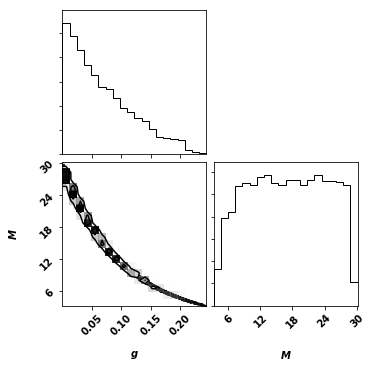

In [21]:
fig = corner.corner(sampler.flatchain, labels=["$g$", "$M$"], figsize=(8,6))
plt.show()

In [22]:
# sample the data to produce the credible intervals
def sample_output(growth_rate, mean_cape, capes, div_yields, num_samples):
    output = np.empty([len(capes), num_samples], dtype=float)
    for i in range(0, num_samples):
        g = growth_rate[random.randint(0, len(growth_rate) - 1)]
        M = mean_cape[random.randint(0, len(mean_cape) - 1)]
        output[:, i] = shiller_pe_model_all(capes, div_yields, g, M)
    return output

In [23]:
sampled_output = sample_output(sampler.flatchain[:,0], sampler.flatchain[:,1], 
                               shiller_data['CAPE'].values[start_index:-1], 
                               shiller_data['div_yield'].values[start_index:-1], 500)

In [31]:
# the 50% and 95% credible intercles
ci95 = np.array([corner.quantile(sampled_output[row, :], [0.025, 0.975]) for row in range(0, len(sampled_output) - 2)]) 
ci50 = np.array([corner.quantile(sampled_output[row, :], [0.25, 0.75]) for row in range(0, len(sampled_output) - 2)])

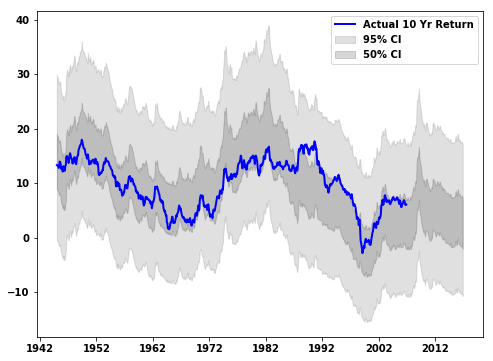

In [34]:
fig = plt.figure(figsize=(8,6))
plt.fill_between(shiller_data.Date.values[start_index:-3], ci95[:,0], ci95[:,1], color=[0.4, 0.4, 0.4], 
                 alpha = 0.2, label="95% CI")
plt.fill_between(shiller_data.Date.values[start_index:-3], ci50[:,0], ci50[:,1], color=[0.2, 0.2, 0.2], 
                 alpha = 0.2, label="50% CI")
plt.plot(dates, ten_year_return, c ='b', lw=2, label='Actual 10 Yr Return')
plt.legend()
plt.show()

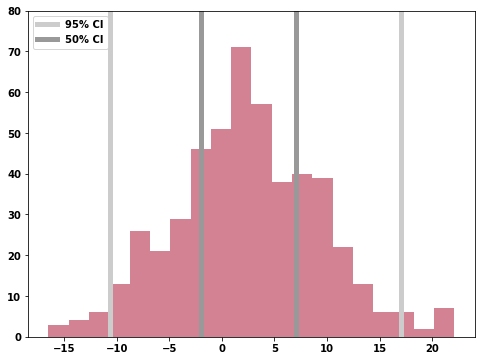

In [40]:
# plot the hist of the latest data
ylim = 80
plt.figure(figsize=(8,6))
plt.plot([ci95[-1,0], ci95[-1, 0]], [0, ylim], c=[0.8, 0.8, 0.8], label="95% CI", lw=5)
plt.plot([ci95[-1,1], ci95[-1, 1]], [0, ylim], c=[0.8, 0.8, 0.8], lw=5)
plt.plot([ci50[-1,0], ci50[-1, 0]], [0, ylim], c=[0.6, 0.6, 0.6], label="50% CI", lw=5)
plt.plot([ci50[-1,1], ci50[-1, 1]], [0, ylim], c=[0.6, 0.6, 0.6], lw=5)
plt.hist(sampled_output[len(sampled_output) - 3, :], 20, histtype="stepfilled", color="#A60628", alpha=0.5)
plt.ylim([0, ylim])
plt.legend()
plt.show()

In [50]:
print("The 95% CI for the current CAPE and dividend yield [{}, {}]".format(ci95[-1,0], ci95[-1, 1]))
print("The 50% CI for the current CAPE and dividend yield [{}, {}]".format(ci50[-1,0], ci50[-1, 1]))
print("Mean for the current CAPE and dividend yield {}%".format(np.mean(sampled_output[-3,:])))

The 95% CI for the current CAPE and dividend yield [-10.660089678019693, 17.002689224678086]
The 50% CI for the current CAPE and dividend yield [-1.979147163963919, 7.045319639319013]
Mean for the current CAPE and dividend yield 2.4226737448377307%


In [43]:
print("10 year actual return for the lower bound is {}%".format( (math.pow(ci95[-1, 0]/100 + 1, 10) - 1)*100))

10 year actual return for the lower bound is -67.60670530550826%
